# Imports

In [140]:
import os
import csv 
import math
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import requests as rq
import statistics as stats
import scipy.stats as stats
import matplotlib.pyplot as plt
from boruta import BorutaPy
from sklearn import datasets
from sklearn import metrics
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

!pip install boruta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download SECOM Data

In [141]:
# Download sensor data file
url1 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'
r1 = rq.get(url1, allow_redirects=True)
open('secomdata.csv', 'wb').write(r1.content)
secom_data = pd.read_csv("secomdata.csv", sep = " ", header = None)
# Renaming sensor dataset columns into feature names 
secom_data.columns = ["feature"+ str(i+1) for i in range(len(secom_data.columns))]


# Download the label File
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'
r = rq.get(url, allow_redirects=True)
open('secomlabels.csv', 'wb').write(r.content)
secom_label = pd.read_csv("secomlabels.csv", sep = " ", header = None)
secom_label.columns=['result','datetime']
# Separate the 'datetime' column into two 'date' and 'time' columns
secom_label['date'] = pd.to_datetime(secom_label['datetime']).dt.date
secom_label['time'] = pd.to_datetime(secom_label['datetime']).dt.time
secom_label.drop('datetime', inplace=True, axis=1)

# Correlation

In [142]:
# Correlation Matrix
corr_df = secom_data.corr()
corr_df
#Remove 0.8 and higher corr values

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
feature1,1.000000,-0.145071,0.004775,-0.007655,-0.011047,NaN,0.002281,0.031510,-0.052731,0.009052,...,-0.070137,-0.028380,0.000225,0.023469,0.019921,0.023605,0.018472,-0.025909,-0.028196,0.004177
feature2,-0.145071,1.000000,0.005802,-0.007603,-0.001641,NaN,-0.025702,-0.012084,0.031321,0.024015,...,0.073211,0.083463,0.043690,0.002905,-0.001264,0.002273,-0.009417,0.017290,0.010134,0.044834
feature3,0.004775,0.005802,1.000000,0.298935,0.095891,NaN,-0.136225,-0.273970,0.023609,0.016291,...,-0.018721,-0.010759,-0.006061,0.015711,0.018237,0.015765,-0.025548,-0.029479,-0.030943,-0.033226
feature4,-0.007655,-0.007603,0.298935,1.000000,-0.058483,NaN,-0.685835,0.138290,-0.103656,0.068998,...,-0.057051,-0.096619,0.009045,0.025461,0.024754,0.026043,0.034779,-0.039309,-0.033780,-0.081157
feature5,-0.011047,-0.001641,0.095891,-0.058483,1.000000,NaN,-0.074368,-0.916410,-0.026035,0.054619,...,-0.041290,0.088327,0.045361,-0.001301,-0.001598,-0.001617,-0.044016,-0.031145,-0.026204,0.051428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature586,0.023605,0.002273,0.015765,0.026043,-0.001617,NaN,-0.039569,0.010345,0.017930,-0.036132,...,-0.000395,-0.000673,-0.197363,0.999890,0.995342,1.000000,0.002744,-0.002931,-0.002531,-0.003801
feature587,0.018472,-0.009417,-0.025548,0.034779,-0.044016,NaN,-0.041296,0.058171,0.010436,0.033759,...,0.249926,-0.475397,-0.016726,0.002257,0.001606,0.002744,1.000000,0.167913,0.164238,-0.486559
feature588,-0.025909,0.017290,-0.029479,-0.039309,-0.031145,NaN,0.034184,-0.021472,0.022853,0.059341,...,0.975470,0.396369,-0.024481,-0.002650,-0.002498,-0.002931,0.167913,1.000000,0.974276,0.390813
feature589,-0.028196,0.010134,-0.030943,-0.033780,-0.026204,NaN,0.032359,-0.020962,0.026261,0.060803,...,1.000000,0.379167,-0.020712,-0.002261,-0.001957,-0.002531,0.164238,0.974276,1.000000,0.389211


In [143]:
# Total Datapoints on Correlation Dataset
print("Total Datapoints in correaltion matrix ",corr_df.count().sum())

# Correlations more than 0.8 and less than -0.8
corr_df_outOfRange = corr_df[((corr_df >= 0.8) | (corr_df <= -0.8)) & (corr_df != 1.0)]
print(f"Count of Highly Correlated datapoints ( >0.8, <-0.8) =  ", corr_df_outOfRange.count().sum())

Total Datapoints in correaltion matrix  224340
Count of Highly Correlated datapoints ( >0.8, <-0.8) =   1346


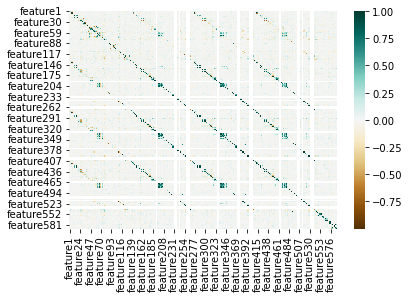

In [144]:
# Correlation Heatmap
sns.heatmap(secom_data.corr(), cmap = "BrBG")

In [145]:
# Filtered correlation within range of -0.8 to 0.8

corr_filtered = corr_df[((corr_df < 0.8) | (corr_df > -0.8))]
corr_filtered

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
feature1,1.000000,-0.145071,0.004775,-0.007655,-0.011047,NaN,0.002281,0.031510,-0.052731,0.009052,...,-0.070137,-0.028380,0.000225,0.023469,0.019921,0.023605,0.018472,-0.025909,-0.028196,0.004177
feature2,-0.145071,1.000000,0.005802,-0.007603,-0.001641,NaN,-0.025702,-0.012084,0.031321,0.024015,...,0.073211,0.083463,0.043690,0.002905,-0.001264,0.002273,-0.009417,0.017290,0.010134,0.044834
feature3,0.004775,0.005802,1.000000,0.298935,0.095891,NaN,-0.136225,-0.273970,0.023609,0.016291,...,-0.018721,-0.010759,-0.006061,0.015711,0.018237,0.015765,-0.025548,-0.029479,-0.030943,-0.033226
feature4,-0.007655,-0.007603,0.298935,1.000000,-0.058483,NaN,-0.685835,0.138290,-0.103656,0.068998,...,-0.057051,-0.096619,0.009045,0.025461,0.024754,0.026043,0.034779,-0.039309,-0.033780,-0.081157
feature5,-0.011047,-0.001641,0.095891,-0.058483,1.000000,NaN,-0.074368,-0.916410,-0.026035,0.054619,...,-0.041290,0.088327,0.045361,-0.001301,-0.001598,-0.001617,-0.044016,-0.031145,-0.026204,0.051428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature586,0.023605,0.002273,0.015765,0.026043,-0.001617,NaN,-0.039569,0.010345,0.017930,-0.036132,...,-0.000395,-0.000673,-0.197363,0.999890,0.995342,1.000000,0.002744,-0.002931,-0.002531,-0.003801
feature587,0.018472,-0.009417,-0.025548,0.034779,-0.044016,NaN,-0.041296,0.058171,0.010436,0.033759,...,0.249926,-0.475397,-0.016726,0.002257,0.001606,0.002744,1.000000,0.167913,0.164238,-0.486559
feature588,-0.025909,0.017290,-0.029479,-0.039309,-0.031145,NaN,0.034184,-0.021472,0.022853,0.059341,...,0.975470,0.396369,-0.024481,-0.002650,-0.002498,-0.002931,0.167913,1.000000,0.974276,0.390813
feature589,-0.028196,0.010134,-0.030943,-0.033780,-0.026204,NaN,0.032359,-0.020962,0.026261,0.060803,...,1.000000,0.379167,-0.020712,-0.002261,-0.001957,-0.002531,0.164238,0.974276,1.000000,0.389211


In [146]:
# Null Values outlier limit

secom_null = secom_data.isna().sum()
secom_null_df = pd.DataFrame(data = secom_null, columns = ["Missing Value"])
nullMean = secom_null_df.mean()
nullStd = secom_null_df.std()
pos1 = nullMean + 3*nullStd
neg1 = nullMean - 3*nullStd
print("Postive outlier limit", pos1)
print("Negative outlier limit", neg1)

Postive outlier limit Missing Value    796.655083
dtype: float64
Negative outlier limit Missing Value   -654.448304
dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e56cd78d0>]],
      dtype=object)

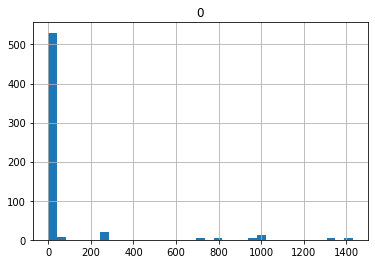

In [147]:
# Distribution of Null Values
null_value = secom_data.isna().sum()
null_hist = pd.DataFrame(data= null_value)
null_hist.hist(bins = 35)

In [148]:
# Count of Missing values outside outlier limit
null_df = secom_null_df[(secom_null_df > pos1) | (secom_null_df < neg1)]
null_df.dropna()
print("Count of missing values outside outlier range ", null_df.count())

Count of missing values outside outlier range  Missing Value    24
dtype: int64


# Find duplicate timestamps in labels

In [149]:
# Finding the duplicates in labels file
secom_label[secom_label.duplicated(['date','time'], keep=False)]

,result,date,time
31,-1,2008-07-27,22:28:00
32,-1,2008-07-27,22:28:00
114,-1,2008-05-08,07:12:00
115,1,2008-05-08,07:12:00
285,-1,2008-08-19,05:11:00
...,...,...,...
1518,-1,2008-10-15,02:40:00
1545,-1,2008-10-16,02:16:00
1546,-1,2008-10-16,02:16:00
1551,-1,2008-10-16,04:02:00


# Volatility Analysis

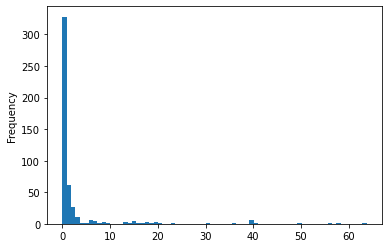

In [150]:
# Volatility analysis
features=[]
# First calculate mean and std dev of each feature and put into DataFrame
for r in secom_data: 
    features.append((np.nanmean(secom_data[r]),np.nanstd(secom_data[r])))
features_df = pd.DataFrame(features)
features_df.columns=['mean', 'std dev']

# Calculate coefficient of variation and append as column to features_df, then plot
features_df['cv'] = features_df['std dev']/abs(features_df['mean'])
features_df['cv'].plot.hist(bins=70)

In [151]:
# Display features with CV > 1
features_df[features_df['cv'] > 1]

,mean,std dev,cv
4,4.197013,56.337393,13.423211
9,-0.000841,0.015111,17.967845
10,0.000146,0.009299,63.801590
24,-298.598136,2901.762592,9.717953
59,2.960241,9.529164,3.219050
...,...,...,...
572,28.450165,86.277139,3.032571
574,9.162315,26.911559,2.937201
576,5.563747,16.915969,3.040392
583,0.015318,0.017174,1.121211


# Merge the label and sensor data

In [152]:
df_merged = pd.concat([secom_label, secom_data], axis=1)

# Split the data

In [153]:
df_non_faulty = df_merged[df_merged['result']== -1]
df_faulty = df_merged[df_merged['result']== 1]

In [154]:
# Split train and test data 80/20 while preserving the ratio of pass/fail cases
faulty_train, faulty_test = train_test_split(df_faulty, test_size=0.2)
nfaulty_train, nfaulty_test = train_test_split(df_non_faulty, test_size=0.2)

df_test_data = pd.concat([faulty_test,nfaulty_test])
df_train_data = pd.concat([faulty_train,nfaulty_train])

In [155]:
df_test_data['result'].value_counts()

-1    293
 1     21
Name: result, dtype: int64

In [156]:
df_train_data['result'].value_counts()

-1    1170
 1      83
Name: result, dtype: int64

# Rough feature removal

In [157]:
# Drop all features with >55% missing values
threshold = int(len(df_train_data) - .55*(len(df_train_data)))
#TODO: come up with better variable name 
#      and refactor in the "Split the data" section
df_train_dropped = df_train_data.dropna(axis=1, thresh=threshold)
df_train_dropped

,result,date,time,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature577,feature578,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
48,1,2008-07-29,15:49:00,2993.59,2345.95,2169.4667,1185.4449,1.2412,100.0,100.8444,...,1.3616,17.0935,0.4976,0.0087,0.0024,1.7469,0.0246,0.0138,0.0037,56.0357
2,1,2008-07-19,13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,...,2.0952,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
326,1,2008-08-20,08:40:00,2973.53,2499.72,2177.3222,1089.3655,1.3101,100.0,101.1478,...,1.7410,12.1012,0.5013,0.0155,0.0036,3.0955,0.0210,0.0156,0.0043,74.0589
158,1,2008-08-08,12:37:00,2964.77,2524.44,2181.5111,1177.0830,1.3012,100.0,100.9333,...,1.1399,14.0347,0.4984,0.0155,0.0040,3.1012,0.0140,0.0180,0.0054,128.2819
236,1,2008-08-17,22:03:00,3035.98,2458.15,2230.0333,1668.6804,1.5739,100.0,99.0522,...,1.1652,9.5646,0.5042,0.0116,0.0030,2.3038,-0.0034,0.0093,0.0030,272.3477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,-1,2008-08-30,02:22:00,2923.26,2548.34,2216.4778,1242.2350,0.8379,100.0,105.1111,...,1.7835,13.1891,0.4955,0.0088,0.0028,1.7740,0.0335,0.0122,0.0040,36.2970
567,-1,2008-08-30,05:51:00,3032.98,2403.47,2180.7000,1159.3838,1.0177,100.0,98.9367,...,1.3091,23.4142,0.5036,0.0136,0.0038,2.6989,0.0348,0.0160,0.0047,45.9641
1412,-1,2008-08-10,05:35:00,3025.46,2516.06,2195.9778,1388.2869,1.5605,100.0,103.2400,...,1.7170,12.6938,0.4985,0.0169,0.0047,3.3884,0.0378,0.0651,0.0195,171.9936
290,-1,2008-08-19,05:54:00,3073.81,2786.97,2178.7333,1039.3641,0.7367,100.0,101.4922,...,1.3412,18.1169,0.5035,0.0166,0.0042,3.2976,0.0037,0.0141,0.0049,382.6619


In [158]:
# Drop all features with 0 variance (constant values)
X_rough = df_train_dropped.drop(df_train_dropped.columns[df_train_dropped.nunique() <=1],axis=1)
X_rough

,result,date,time,feature1,feature2,feature3,feature4,feature5,feature7,feature8,...,feature577,feature578,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
48,1,2008-07-29,15:49:00,2993.59,2345.95,2169.4667,1185.4449,1.2412,100.8444,0.1221,...,1.3616,17.0935,0.4976,0.0087,0.0024,1.7469,0.0246,0.0138,0.0037,56.0357
2,1,2008-07-19,13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,...,2.0952,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
326,1,2008-08-20,08:40:00,2973.53,2499.72,2177.3222,1089.3655,1.3101,101.1478,0.1216,...,1.7410,12.1012,0.5013,0.0155,0.0036,3.0955,0.0210,0.0156,0.0043,74.0589
158,1,2008-08-08,12:37:00,2964.77,2524.44,2181.5111,1177.0830,1.3012,100.9333,0.1215,...,1.1399,14.0347,0.4984,0.0155,0.0040,3.1012,0.0140,0.0180,0.0054,128.2819
236,1,2008-08-17,22:03:00,3035.98,2458.15,2230.0333,1668.6804,1.5739,99.0522,0.1204,...,1.1652,9.5646,0.5042,0.0116,0.0030,2.3038,-0.0034,0.0093,0.0030,272.3477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,-1,2008-08-30,02:22:00,2923.26,2548.34,2216.4778,1242.2350,0.8379,105.1111,0.1233,...,1.7835,13.1891,0.4955,0.0088,0.0028,1.7740,0.0335,0.0122,0.0040,36.2970
567,-1,2008-08-30,05:51:00,3032.98,2403.47,2180.7000,1159.3838,1.0177,98.9367,0.1222,...,1.3091,23.4142,0.5036,0.0136,0.0038,2.6989,0.0348,0.0160,0.0047,45.9641
1412,-1,2008-08-10,05:35:00,3025.46,2516.06,2195.9778,1388.2869,1.5605,103.2400,0.1234,...,1.7170,12.6938,0.4985,0.0169,0.0047,3.3884,0.0378,0.0651,0.0195,171.9936
290,-1,2008-08-19,05:54:00,3073.81,2786.97,2178.7333,1039.3641,0.7367,101.4922,0.1219,...,1.3412,18.1169,0.5035,0.0166,0.0042,3.2976,0.0037,0.0141,0.0049,382.6619


# Imputation

#### Data Scaling

In [159]:
# Scale the data
y_train = X_rough['result']

X_rough_features = X_rough.drop(['result','date','time'],axis=1)
minmax_scaler = preprocessing.MinMaxScaler()
X_rough_normalized = pd.DataFrame(minmax_scaler.fit_transform(X_rough_features.values)) #takes a numpy array
X_rough_normalized.isna().sum().sum()

# Potential problem: min max scaling not as robust to new data
#                    because the new data may contain new mins
#                    and maxes, therefore affecting the scale of
#                    the initial transformation

# Reason for min max: https://stats.stackexchange.com/questions/363889/which-type-of-data-normalizing-should-be-used-with-knn

11250

#### KNN

In [160]:
# Creating 2 knn imputers to measure whether scaling is done automatically in sklearn
knn_imputer = KNNImputer()
knn_imputer_norm = KNNImputer()

knn_imputed_df = pd.DataFrame(knn_imputer.fit_transform(X_rough_features))
knn_imputed_df_norm = pd.DataFrame(knn_imputer_norm.fit_transform(X_rough_normalized))

knn_imputed_norm_rescaled = pd.DataFrame(minmax_scaler.inverse_transform(knn_imputed_df_norm))
knn_imputed_norm_rescaled

# Used for dynamic output later
which_imputer = 'KNN'
imputer = knn_imputer_norm

In [161]:
knn_imputed_norm_rescaled.isna().sum().sum()

0

#### MICE

In [162]:
# Important: MICE assumes that data is missing at random
lr = LinearRegression()
mice_imputer = IterativeImputer(estimator = lr, verbose = 2, max_iter = 5, tol = 1e-10, imputation_order = "roman")
X_train_mice_norm = mice_imputer.fit_transform(X_rough_normalized)
mice_imputed_norm_rescaled = pd.DataFrame(minmax_scaler.inverse_transform(X_train_mice_norm))
mice_imputed_norm_rescaled

# Used for dynamic output later
which_imputer = 'MICE'
imputer = mice_imputer

[IterativeImputer] Completing matrix with shape (1253, 450)
[IterativeImputer] Ending imputation round 1/5, elapsed time 62.02
[IterativeImputer] Change: 3153.686448357477, scaled tolerance: 1.0000000000000004e-10 
[IterativeImputer] Ending imputation round 2/5, elapsed time 106.20
[IterativeImputer] Change: 141.1707340754357, scaled tolerance: 1.0000000000000004e-10 
[IterativeImputer] Ending imputation round 3/5, elapsed time 151.40
[IterativeImputer] Change: 124.53399664020071, scaled tolerance: 1.0000000000000004e-10 
[IterativeImputer] Ending imputation round 4/5, elapsed time 195.21
[IterativeImputer] Change: 18.184373756694185, scaled tolerance: 1.0000000000000004e-10 
[IterativeImputer] Ending imputation round 5/5, elapsed time 239.69
[IterativeImputer] Change: 3.529286130751643, scaled tolerance: 1.0000000000000004e-10 


/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


In [163]:
mice_imputed_norm_rescaled.isna().sum().sum()

0

# Feature Selection

#### Boruta

In [170]:
###initialize Boruta
forest = RandomForestClassifier(
   n_jobs = -1, 
   max_depth = 5,
   n_estimators=500#,
   #random_state=2
)
boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 'auto',
   max_iter = 100#, # number of trials to perform
   #random_state=4
)

if which_imputer == 'KNN':
  imputed_df = knn_imputed_norm_rescaled
elif which_imputer == 'MICE':
  imputed_df = mice_imputed_norm_rescaled
print("Boruta running with {} imputer".format(which_imputer))

# Choose how many times to run Boruta
num_boruta_iterations = 1

boruta_runs = dict()
predictive_power = dict()
for i in range(num_boruta_iterations):
  ### fit Boruta (it accepts np.array, not pd.DataFrame)
  boruta.fit(np.array(imputed_df), np.array(y_train))
  green_area = imputed_df.columns[boruta.support_].to_list()
  blue_area = imputed_df.columns[boruta.support_weak_].to_list()
  # Store each run of boruta as a 2d array in boruta_runs map
  # First row of each array is the green area, second row is the blue area
  boruta_runs[i] = [green_area, blue_area]
  print('run {}: \nfeatures in the green area: {}\nfeatures in the blue area: {}'.format(i, green_area, blue_area))
  # Weight green/blue area to calculate overrall predictive power of features
  for feat in green_area:
    predictive_power[feat] = 3 if feat not in predictive_power else predictive_power[feat] + 3
  for feat in blue_area:
    predictive_power[feat] = 1 if feat not in predictive_power else predictive_power[feat] + 1


Boruta running with MICE imputer
run 0: 
features in the green area: [19, 54, 59, 60, 139, 232, 281, 329, 333]
features in the blue area: [14, 24, 25, 426]


In [171]:
# Selected features with predictive_power >= num_boruta_iterations
selected_features = []
for feat in predictive_power:
  if predictive_power[feat] >= num_boruta_iterations:
    selected_features.append(feat)

X_train_boruta = imputed_df[selected_features]
X_train_boruta

,19,54,59,60,139,232,281,329,333,14,24,25,426
0,-5300.25,25.0382,14.9618,20.2052,0.7397,0.2253,0.0235,7.5628,10.8708,9.7807,2.0105,7.2763,261.338000
1,-5447.75,23.8245,16.1755,24.2829,0.4909,0.1479,0.0105,5.2707,3.5220,9.3144,2.0295,7.5788,267.064000
2,-6390.00,14.7500,25.2500,32.5387,0.2949,0.1000,0.0298,3.0529,2.0489,9.6599,1.8872,5.1517,267.729834
3,-6349.50,-12.1527,32.1527,42.2381,0.4411,0.1331,0.0132,4.4661,3.1675,9.8767,1.8818,5.0897,262.136000
4,-5505.50,8.4236,31.5764,40.0125,0.4140,0.1224,0.0347,3.9838,8.0658,10.3911,1.9985,7.3620,262.592000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,-5630.75,0.2536,19.7464,28.3785,0.4394,0.1290,0.0257,4.5602,1.6498,9.6348,1.9838,7.4213,256.888481
1249,-5361.50,8.9864,11.0136,17.1276,1.3279,0.3562,0.0169,13.9201,3.3576,9.5397,2.0023,7.3960,259.810603
1250,-5689.00,-1.4609,21.4609,28.8331,0.4018,0.1187,0.0156,4.1575,3.4990,9.6645,1.9942,7.3293,264.272000
1251,-6322.00,17.7327,22.2673,30.2505,0.9268,0.2756,0.0385,9.2202,4.0340,10.0514,1.8980,5.1763,271.382965


#### RFE

# Evaluate on Test data

In [172]:

X_test_dropped = df_test_data[X_rough.drop(['result','date','time'],axis=1).columns]
X_test_imputed = pd.DataFrame(imputer.transform(X_test_dropped))
X_test_boruta = X_test_imputed[selected_features]
X_test_boruta

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but IterativeImputer was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


[IterativeImputer] Completing matrix with shape (314, 450)
[IterativeImputer] Ending imputation round 1/5, elapsed time 0.12
[IterativeImputer] Ending imputation round 2/5, elapsed time 0.27
[IterativeImputer] Ending imputation round 3/5, elapsed time 0.38
[IterativeImputer] Ending imputation round 4/5, elapsed time 0.49
[IterativeImputer] Ending imputation round 5/5, elapsed time 0.61


,19,54,59,60,139,232,281,329,333,14,24,25,426
0,-6405.75,53.6818,42.6300,56.8964,0.6789,0.1961,0.0230,6.6675,2.5504,10.1819,1.8880,5.1162,2.462880e+02
1,-5394.00,23.9555,16.0445,21.1546,0.3621,0.1051,0.0120,3.6058,2.9109,10.0409,2.0032,7.2175,9.885633e+06
2,-5714.25,4.6209,15.3791,22.4441,0.4588,0.1332,0.0186,4.2815,2.7241,10.7168,2.0110,7.4093,2.642720e+02
3,-4970.75,-1.4200,21.4200,27.1504,0.9305,0.2792,0.0119,9.0370,5.8098,10.2970,1.9963,7.2257,2.471100e+02
4,-5392.25,9.8782,30.1218,37.9277,0.9620,0.2565,0.0242,9.9464,3.4819,9.6715,2.0088,7.4315,2.475480e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,-5819.75,-2.5955,22.5955,25.7407,0.9835,0.2871,0.0256,10.9135,3.1097,9.0113,2.0082,7.3548,2.663280e+02
310,-5759.50,-0.0182,20.0182,23.1901,0.5441,0.1587,0.0153,5.6314,4.5172,9.6623,1.9973,7.3607,2.642720e+02
311,-5160.25,7.9755,12.0245,17.5921,1.1027,0.2965,0.0150,11.1251,4.4883,9.9121,2.0042,7.3805,4.598979e+07
312,-5605.00,2.0673,17.9327,24.3585,0.3426,0.1129,0.0156,3.4841,2.1558,9.8322,1.9715,7.2182,2.642720e+02


In [173]:
y_true = pd.Series(df_test_data['result'])

In [174]:
rf_clf = RandomForestClassifier(
   n_jobs = -1, 
   max_depth = 5
)

rf_clf.fit(X_train_boruta, y_train)
y_pred_rf = pd.Series(rf_clf.predict(X_test_boruta))


conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred_rf)
print("using {} imputed data".format(which_imputer))
print("random forest confusion matrix: \n{}".format(conf_matrix))
# Accuracy: overall predictive accuracy
print("random forest accuracy: {}".format(accuracy_score(y_true, y_pred_rf)))

# Precision: How correctly you classify positives relative to only all the pos pred you gave: TP / (TP + FP)
print("random forest precision: {}".format(precision_score(y_true, y_pred_rf, pos_label=-1)))

# Sensitivity/Recall: How correctly you classify positives relative to pos/neg pred you gave: TP / (TP + FN)
print("random forest recall: {}".format(recall_score(y_true, y_pred_rf, pos_label=-1)))

# Specificity: How correctly you classify negatives relative to pos/neg pred you gave: TN / (TN + FP)
print("random forest specificity: {}".format(conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])))

using MICE imputed data
random forest confusion matrix: 
[[292   1]
 [ 21   0]]
random forest accuracy: 0.9299363057324841
random forest precision: 0.9329073482428115
random forest recall: 0.9965870307167235
random forest specificity: 0.0


In [175]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train_boruta, y_train)
y_pred_svm = pd.Series(clf.predict(X_test_boruta))
y_pred_svm.value_counts()

conf_matrix_svm = confusion_matrix(y_true=y_true, y_pred=y_pred_svm)
print("using {} imputed data".format(which_imputer))
print("SVM confusion matrix: \n{}".format(conf_matrix_svm))
# Accuracy: overall predictive accuracy
print("SVM accuracy: {}".format(accuracy_score(y_true, y_pred_svm)))

# Precision: How correctly you classify positives relative to only all the pos pred you gave: TP / (TP + FP)
print("SVM precision: {}".format(precision_score(y_true, y_pred_svm, pos_label=-1)))

# Sensitivity/Recall: How correctly you classify positives relative to pos/neg pred you gave: TP / (TP + FN)
print("SVM recall: {}".format(recall_score(y_true, y_pred_svm, pos_label=-1)))

# Specificity: How correctly you classify negatives relative to pos/neg pred you gave: TN / (TN + FP)
print("SVM specificity: {}".format(conf_matrix_svm[1][1] / (conf_matrix_svm[1][1] + conf_matrix_svm[1][0])))

using MICE imputed data
SVM confusion matrix: 
[[293   0]
 [ 21   0]]
SVM accuracy: 0.9331210191082803
SVM precision: 0.9331210191082803
SVM recall: 1.0
SVM specificity: 0.0
